In [2]:
import numpy as np
from src.PorfolioOptimizerSA import PortfolioOptimizerSA 

from src.analysis import (
    plot_cvar_history,
    return_rate_influence,
    plot_return_rate_influence,
    plot_weights,
    analyze_different_portfolios,
    plot_regularization_weights,
    probabilities_ifluence,
    examine_num_of_scenarios_influence
)

### Losowanie scenariuszy (akcje nieskorelowane)
Dodajemy możliwość generowania scenariuszy zmiany cen akcji. Cena akcji wówczas  $S_T = \alpha S_0$, gdzie $\alpha$ oznacza:
- duży spadek: $\alpha \sim \mathcal{N}(0.6, 0.1)$
- brak zmiany: $\alpha \sim \mathcal{N}(1, 0.1)$  
- duży wzrost: $\alpha \sim \mathcal{N}(1.4, 0.1)$

Wybór współczynnika $\alpha$ odbywa się losowo z powyższych rozkładów z prawdopodobieństwami $[0.1, 0.8, 0.1]$. 

### Losowanie scenariuszy (akcje skorelowane)
Prawdopodobieństwa j.w. Dodatkowo uwzględniamy korelację między cenami dwóch pierwszych instrumentów.

In [3]:
def generate_scenarios_uncor(S_0, number_of_scenarios=1000):
    """
    Generuje losowe scenariusze na podstawie stanu początkowego.
    
    """
    
    p = np.array([0.1, 0.8, 0.1])
    scenarios = np.zeros((number_of_scenarios, len(S_0)))
    for i in range(number_of_scenarios):
        coefs = [np.random.normal(0.6, 0.1), 
                 np.random.normal(1, 0.1),
                 np.random.normal(1.4, 0.1)]
        chosen = np.random.choice(coefs, size=len(S_0), p=p)
        
        S_T = S_0 * chosen
        scenarios[i] = S_T
    
    return scenarios

def generate_scenarios_corr(S_0, number_of_scenarios=1000, correlated_indices=[0,1], rho=0.5, return_rate=0.05):
    assert len(correlated_indices) == 2, "Two indices must be provided for correlation."
    
    n = len(S_0)
    scenarios = np.zeros((number_of_scenarios, n))
    
    sigmas = np.array([0.05, 0.1, 0.05, 0.1, 0.001, 0.02, 0.1, 0.1][:n])  
    
    cov_matrix = np.diag(sigmas**2)
    i, j = correlated_indices
    cov_matrix[i,j] = cov_matrix[j,i] = rho * sigmas[i] * sigmas[j]
    
    means = np.full(n, return_rate) - 0.5 * sigmas**2
    
    for i in range(number_of_scenarios):
        coefs = np.random.multivariate_normal(means, cov_matrix)
        S_T = S_0 * np.exp(coefs)
        scenarios[i] = S_T
    return scenarios
        

prawdopodobieństwo występienia i-tego scenariusza $p_i$ nie jest jednostajne - zakładamy pewną wiedzę ekspercką o rynku

In [4]:
# lcizba scenariuszy 
number_of_scenarios = 1000

# stan początkowy
S_0 = np.array([100, 100, 100, 100, 100])

# stany
S_T_corr = generate_scenarios_corr(S_0, number_of_scenarios=number_of_scenarios)
S_T_uncorr = generate_scenarios_uncor(S_0, number_of_scenarios=number_of_scenarios)

# prawdopodobieństwa
probabilities = 1 / np.arange(1, number_of_scenarios + 1)
# prawdopodobieństwa znormalizowane
probabilities /= probabilities.sum()

probabilities_uniform = np.ones(number_of_scenarios) / number_of_scenarios

# poziom ufności
alpha = 0.95

# wartość portfela na początku
V_0 = 10000

# stopa zwrotu
return_rate = 0.05

# parametry symulowanego wyżarzania
T_0 = 1000  # początkowa temperatura
T_f = 0.00001  # temperatura końcowa
max_iter = 1000  # maksymalna liczba iteracji
step_size = 10  # wielkość kroku
annealing_rate = 0.99  # współczynnik chłodzenia

### Proces optymalizacji

Akcje nieskorelowane

Ścieżka 1: Końcowe CVaR/V0 = 0.2931
Ścieżka 2: Końcowe CVaR/V0 = 0.2930
Ścieżka 3: Końcowe CVaR/V0 = 0.2931
Ścieżka 4: Końcowe CVaR/V0 = 0.2931
Ścieżka 5: Końcowe CVaR/V0 = 0.2931
Ścieżka 6: Końcowe CVaR/V0 = 0.2932
Ścieżka 7: Końcowe CVaR/V0 = 0.2930


/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


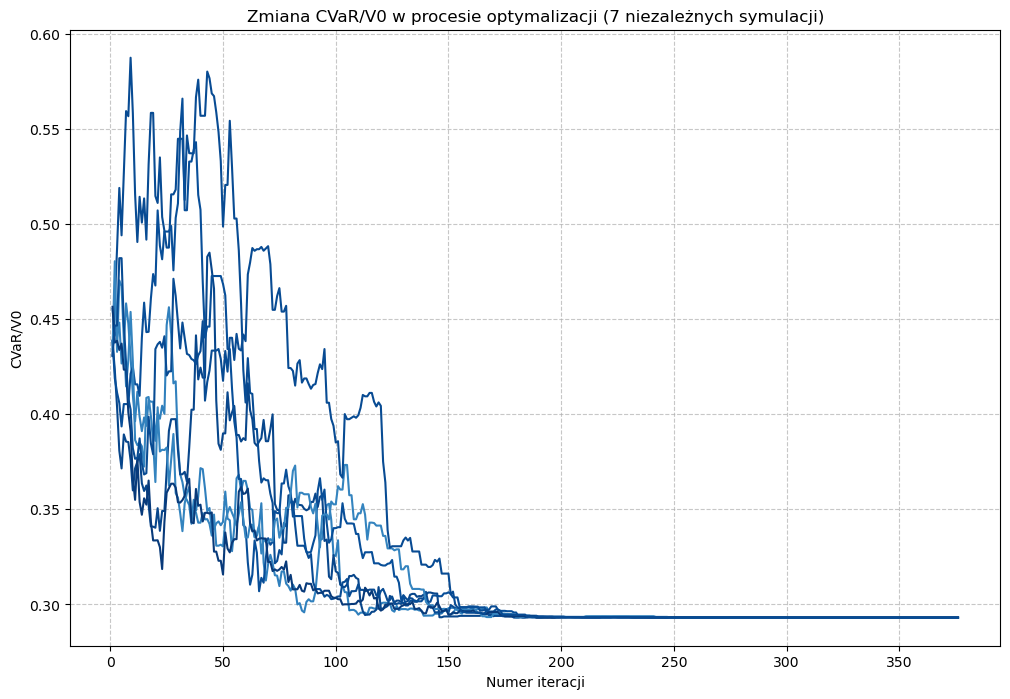

In [8]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities,
                  alpha = alpha,
                  S_0 = S_0,
                  S_T = S_T_uncorr,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=7,
                  relative=True)

Akcje skorelowane.

/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


Ścieżka 1: Końcowe CVaR/V0 = -0.0436
Ścieżka 2: Końcowe CVaR/V0 = -0.0446
Ścieżka 3: Końcowe CVaR/V0 = -0.0423
Ścieżka 4: Końcowe CVaR/V0 = -0.0424
Ścieżka 5: Końcowe CVaR/V0 = -0.0439
Ścieżka 6: Końcowe CVaR/V0 = -0.0453
Ścieżka 7: Końcowe CVaR/V0 = -0.0436


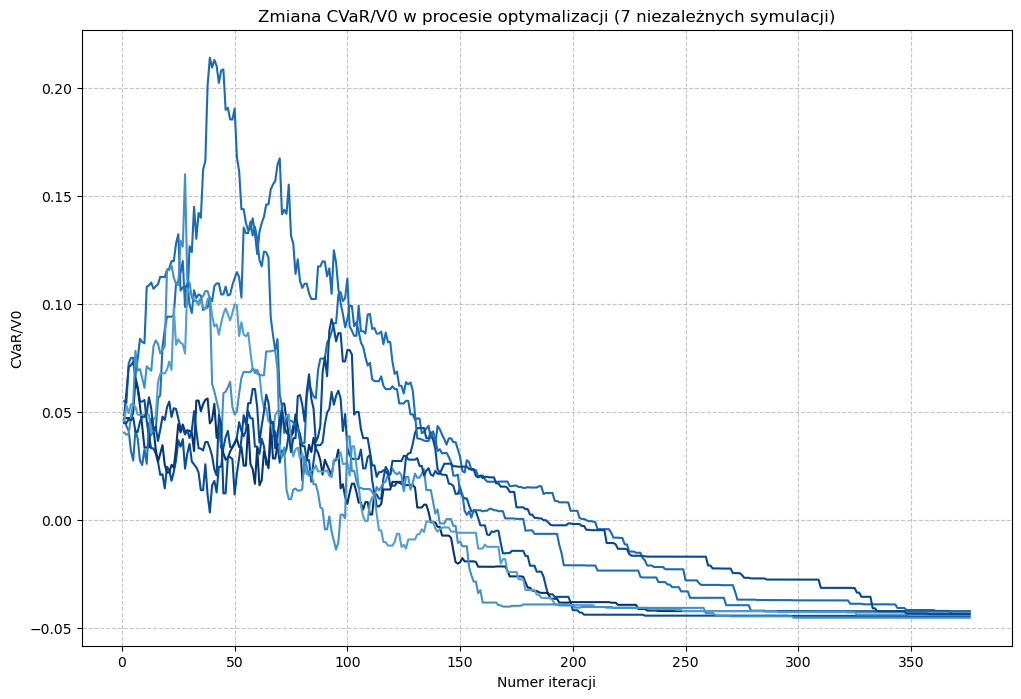

In [9]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities,
                  alpha = alpha,
                  S_0 = S_0,
                  S_T = S_T_corr,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=7, 
                  relative=True)

### Wpływ stopy zwrotu

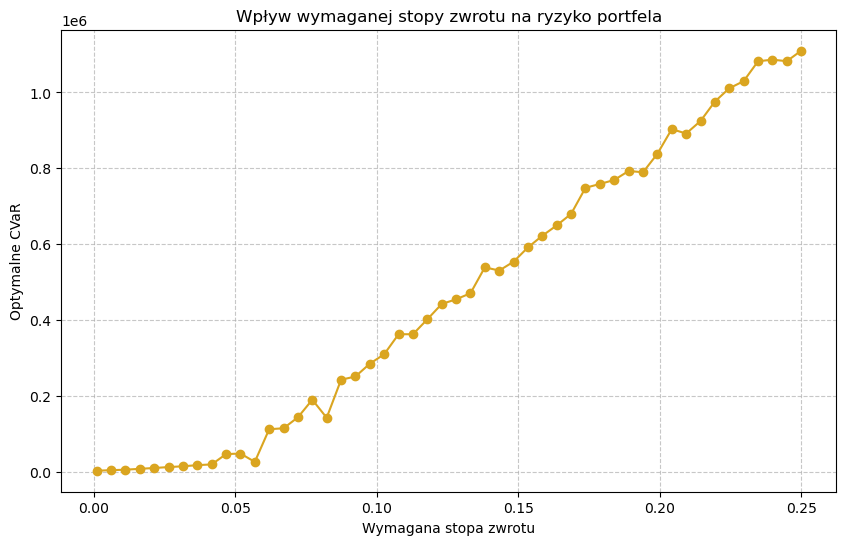

In [12]:
res = return_rate_influence(T_0=T_0,
                            T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities_uniform,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T_uncorr,
                            V_0=V_0,
                            return_rates=np.linspace(0.001, 0.25, 50))
plot_return_rate_influence(res)

### Zmiana ilości akcji w portfelu w procesie optymalizacji

In [5]:
optimizer = PortfolioOptimizerSA(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T_uncorr,
    V_0=V_0,
    return_rate=return_rate, 
    initial_portfolio=np.array([0, 0, 0, 0, 0])
)
optimizer.optimize()

optimal_portfolio = optimizer.x
optimal_CVaR = optimizer.calculate_CVaR(optimal_portfolio)

print("Optymalny portfel:", optimal_portfolio)
print("Wartość CVaR:", optimal_CVaR)

plot_weights(optimizer, './visualizations/weights_gen.gif', plot_every_k_iterations=5, fps=20)

Optymalny portfel: [ 31  66   7  19 -23]
Wartość CVaR: 2929.5979618362403


### Wpływ wyboru początkowego portfela

Akcje nieskorelowane

In [8]:
analyze_different_portfolios(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T_uncorr,
    V_0=V_0,
    return_rate=return_rate,
    relative=True,
    initial_portfolios=[np.array([10, 20, 30, 40, 50]), np.array([5, 15, 25, 35, 45]), np.array([20, 30, 40, 50, 60]),
                        np.array([0, 0, 0, 0, 100]), np.array([100, 100, 100, 100, 100]), np.array([1000, 10, 1000, 0, 1])],
)

Nr   Portfel początkowy                       Portfel optymalny                        CVaR / V0      
------------------------------------------------------------------------------------------------------
1    [10 20 30 40 50]                         [ 30  64  12  21 -27]                    0.292647       
2    [ 5 15 25 35 45]                         [ 27  64  20  17 -28]                    0.292920       
3    [20 30 40 50 60]                         [ 31  64  10  22 -27]                    0.293088       
4    [  0   0   0   0 100]                    [ 30  67   3  21 -21]                    0.293893       
5    [100 100 100 100 100]                    [ 31  65  10  19 -25]                    0.292636       
6    [1000   10 1000    0    1]               [-113  -23  671 -179 -256]               3.080822       


Akcje skorelowane

In [9]:
analyze_different_portfolios(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T_corr,
    V_0=V_0,
    return_rate=return_rate,
    initial_portfolios=[np.array([10, 20, 30, 40, 50]), np.array([5, 15, 25, 35, 45]), np.array([20, 30, 40, 50, 60]),
                        np.array([0, 0, 0, 0, 100]), np.array([100, 100, 100, 100, 100]), np.array([1000, 10, 1000, 0, 1])],
    
)

/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


Nr   Portfel początkowy                       Portfel optymalny                        CVaR           
------------------------------------------------------------------------------------------------------
1    [10 20 30 40 50]                         [ 5  0 10 -3 88]                         -396.087229    
2    [ 5 15 25 35 45]                         [ 4  0  7 -3 92]                         -412.622237    
3    [20 30 40 50 60]                         [  1   0  -2  -3 104]                    -436.961048    
4    [  0   0   0   0 100]                    [ 3  0  3 -3 97]                         -427.992241    
5    [100 100 100 100 100]                    [ 4  0  9 -3 90]                         -402.012573    
6    [1000   10 1000    0    1]               [-711  210  723   16 -138]               8341.517748    


### Regularyzacja

/Users/julia/Desktop/semestr-6/azlm/projekt/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


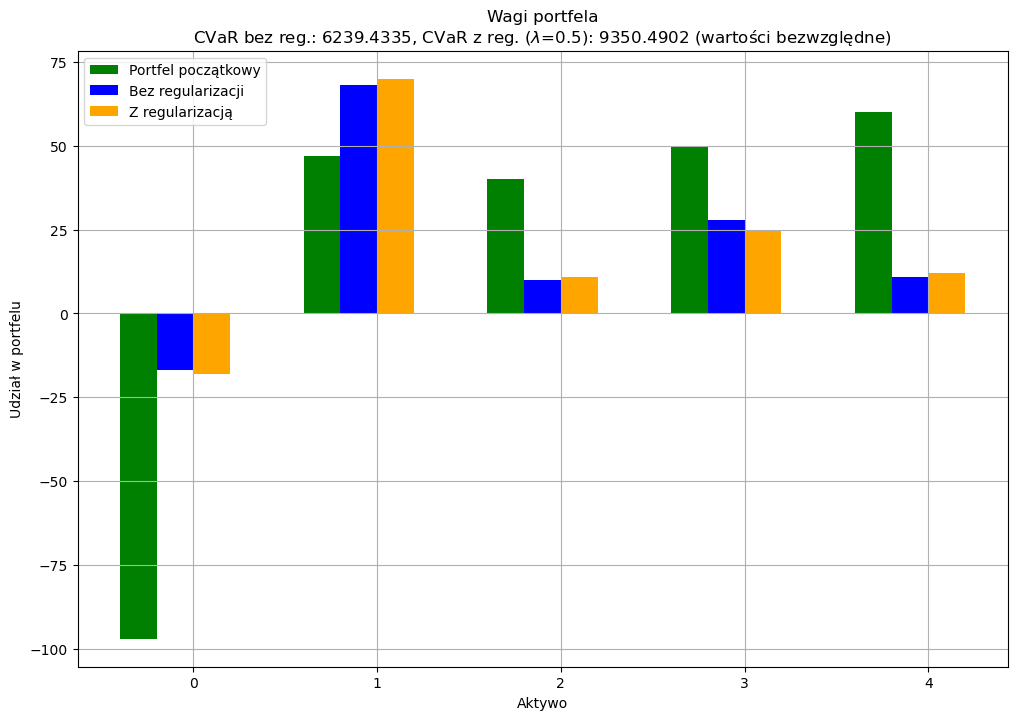

CVaR bez regularizacji: 6239.43
CVaR z regularizacją ($\lambda$=0.5): 9350.49


In [10]:
plot_regularization_weights(T_0=T_0,
                             T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rate=return_rate,
                            regularization_lambda=0.5,
                            initial_portfolio=np.array([20, 30, 40, 50, 60]),)

/Users/julia/Desktop/semestr-6/azlm/projekt/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


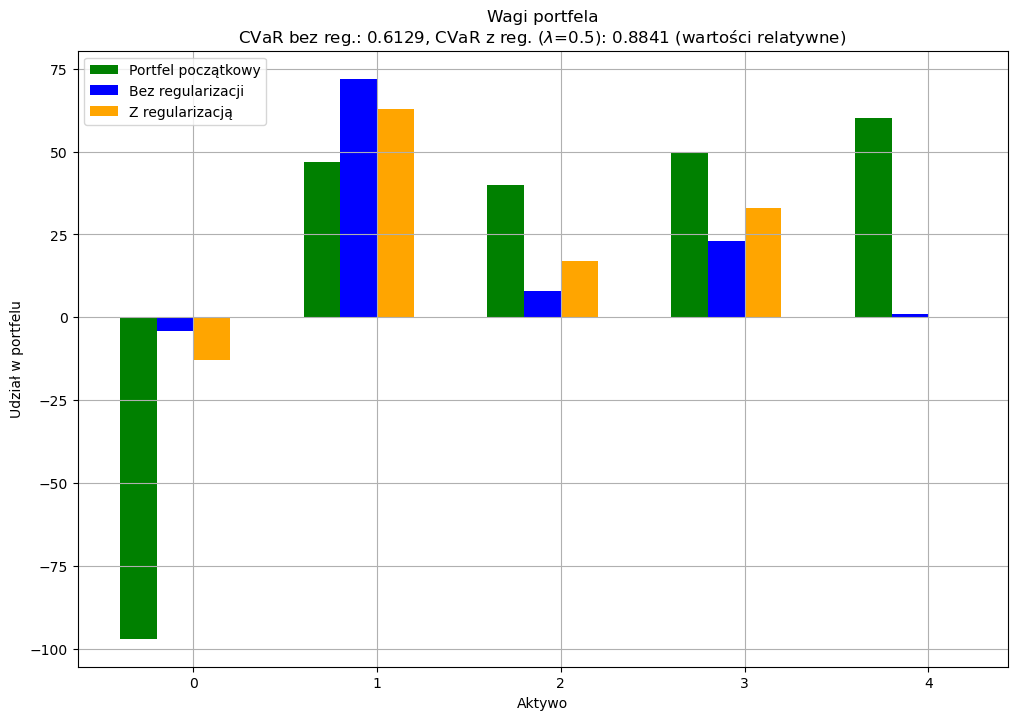

CVaR bez regularizacji: 0.6129 (relatywne)
CVaR z regularizacją ($\lambda$=0.5): 0.8841 (relatywne)


In [11]:
plot_regularization_weights(T_0=T_0,
                             T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rate=return_rate,
                            regularization_lambda=0.5,
                            initial_portfolio=np.array([20, 30, 40, 50, 60]),
                            relative=True)

### CVar vs. liczba mozliwych scenariuszy

In [ ]:
# stan początkowy
S_0_1 = np.array([100, 100, 100, 100, 100])

# stany
S_T_1 = generate_scenarios_uncor(S_0_1, number_of_scenarios=1_000_000)

# prawdopodobieństwa
probabilities_1 = 1 / np.arange(1, S_T_1.shape[0] + 1)
# prawdopodobieństwa znormalizowane
probabilities_1 /= probabilities_1.sum()

In [ ]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities_1,
                  alpha = alpha,
                  S_0 = S_0_1,
                  S_T = S_T_1,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=5)

In [ ]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities_1,
                  alpha = alpha,
                  S_0 = S_0_1,
                  S_T = S_T_1,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=5,
                  relative=True)

### Wpływ prawdopodobieństw na wartość CVaR

In [5]:
probabilities_ifluence(T_0=T_0,
                            T_f=T_f,
                          max_iter=max_iter,
                          step_size=step_size,
                          annealing_rate=annealing_rate,
                          probabilities=[probabilities, probabilities_uniform],
                          alpha=alpha,
                          S_0=S_0,
                          S_T=S_T_uncorr,
                          V_0=V_0,
                          return_rate=return_rate,
                          n_paths=10)

/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


    probabilities      mean_CVaR     std_CVaR
--  ---------------  -----------  -----------
 0  non-uniform             0.31  5.28819e-05
 1  uniform                 1.67  0.00932323


In [6]:
# examine_num_of_scenarios_influence(
#     T_0=T_0,
#     T_f=T_f,
#     max_iter=max_iter,
#     step_size=step_size,
#     annealing_rate=annealing_rate,
#     alpha=alpha,
#     S_0=S_0,
#     S_T=S_T,
#     V_0=V_0,
#     return_rate=return_rate,
#     nums_of_scenarios=[100, 1000, 10000, 100000, 1000_000],
#     n_paths=5,
#     probabilities='uniform'
# )